In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import spacy
import nltk
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from sklearn.feature_extraction import stop_words as sklearn_stopwords
from nltk.corpus import stopwords as nltk_stopwords

In [265]:
df = pd.read_csv('/home/cneiderer/Downloads/inaug_speeches_mod.csv')

In [266]:
df.head()

,Unnamed: 0,Name,Inaugural Address,Date,text
0,4,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and o...
1,5,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again calle...
2,6,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in ea..."
3,7,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CALL...
4,8,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to th..."


In [267]:
docs = list(df.text)
len(docs)

58

In [268]:
import re

# custom stop words and stop phrases
custom_stopwords = ['mr', 'miss', 'vice president', 'chief justice', 'united states', 'god bless', 
                    'fellow citizens', 'fellow-citizens', 'government']
docs_orig = docs.copy()
for wd in custom_stopwords:
    for idx in range(len(docs)):
        docs[idx] = re.sub(wd, ' ', docs[idx], flags=re.I)
        docs[idx] = re.sub('<[Uu]\+\d{4,4}>', ' ', docs[idx])

In [269]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
lmtzr = nltk.stem.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# for idx, doc in enumerate(docs):
    
#     processed_words = []    
#     sentences = sent_tokenize(doc)
#     for sentence in sentences:
#         words = word_tokenize(sentence)
#         for word in words:
#             processed_words.append(lmtzr.lemmatize(word))
# #             processed_words.append(stemmer.stem(word))
# #             processed_words.append(lmtzr.lemmatize(stemmer.stem(word)))
                               
#     docs[idx] = ' '.join(processed_words)          

In [270]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [271]:
n_features = 2500
n_topics = 3
n_top_words = 20

In [272]:
# Helper Function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]), '\n')
    print()

In [273]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 4), max_df=0.8, min_df=0.02,    
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(docs)

In [277]:
nmf = NMF(n_components=n_topics, random_state=129, alpha=.1, l1_ratio=0.2)
nmf.fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
public union constitution states congress laws interests foreign state war executive duties policy powers national best revenue general administration present 

Topic #1:
america let americans today freedom work american know century generation history make promise children man day journey god change earth 

Topic #2:
peace peoples freedom economic democracy purpose know justice things industrial action problems counsel mankind help progress conditions leadership self civilization 




In [278]:
component_dicts = []

components = nmf.components_
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(tfidf_feature_names, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:20], "\n")
    
    component_dicts.append(dict(sorted(temp, key=lambda x: x[1], reverse=True)[:20]))

topic 0
[('public', 0.21320975347864107), ('union', 0.19585718799582444), ('constitution', 0.19361496284240065), ('states', 0.17836063085463549), ('congress', 0.1170500461982089), ('laws', 0.11475340547967548), ('interests', 0.11233887800651181), ('foreign', 0.10890233726631735), ('state', 0.10371614221646028), ('war', 0.099555506673280503), ('executive', 0.099338059921937158), ('duties', 0.096408585154965656), ('policy', 0.096097588230727268), ('powers', 0.095741563856454798), ('national', 0.094898125472546405), ('best', 0.09175467577862767), ('revenue', 0.086134484575387943), ('general', 0.084952428606923369), ('administration', 0.082650600285169601), ('present', 0.082488466396879026)] 

topic 1
[('america', 0.4227464187288047), ('let', 0.21042142267429725), ('americans', 0.20243637121365235), ('today', 0.19943005297175095), ('freedom', 0.17813130403776054), ('work', 0.12229645239673821), ('american', 0.11235944856899877), ('know', 0.10898235124878049), ('century', 0.1055473264360503

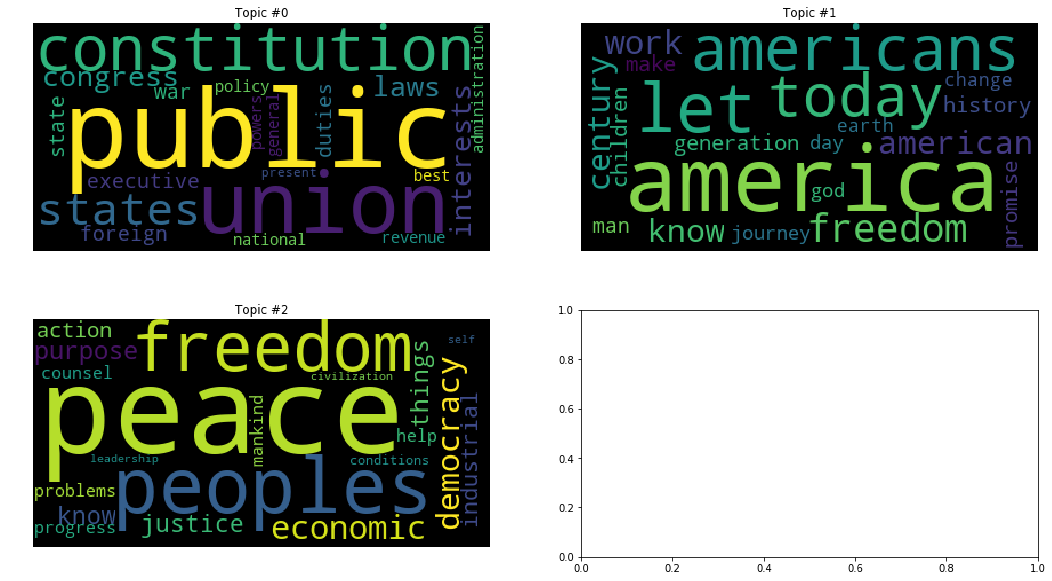

In [279]:
ncol = 2
nrow = int(np.ceil(len(component_dicts) / ncol))

figwidth = ncol * 9
figheight = nrow * 5
fig, axes = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
ax = axes.flatten()

num_words = 20 # Number of words to include in word cloud
for t in range(len(component_dicts)): 
    plt.sca(ax[t])    
    plt.title("Topic #" + str(t))
    plt.axis("off")    
    plt.imshow(WordCloud().fit_words(component_dicts[t]))